각 변수의 데이터 종류
+ sessionID: 각 세션을 표현하는 Key값. 중복없음.
+ [userID](##userID) : 80%의 유저는 한번의 session을 발생시킴. 2번 이상 접속한 인원은 26258명
+ [TARGET](##target) : 수치/연속형 자료. 값의 범위는 1.0 ~ 386.0. float형이지만 모두 정수값만 있음.
+ [browser](##browser) : 범주형. 70개의 브라우저가 사용됨. 특히 빈도가 1인 값들은 특정 브라우저를 알 수 없는 값. Null로 간주해도 될 것으로 보임
+ [OS](##OS) : 범주형. 20개의 OS가 사용됨. Null 값이 존재하는데, (not set)이란 형태로 되어있다.
+ [devices](##device) : 범주형. 3개의 데이터가 사용됨. 66%가 PC, 30%가 mobile, 나머지 약 4%가 tablet


In [2]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

C:\Users\kyeul\AppData\Local\Temp\ipykernel_19576\100573275.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Fixed Random-Seed
동일한 결과를 위한 seed 고정

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## Load Data
train.csv, test.csv 파일을 불러오자.

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## 각 feature의 데이터 종류를 뜯어보자. 
+ 수치형
    + 연속형
    + 이산형
+ 범주형

In [5]:
train.sample(10)

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
33522,SESSION_033522,USER_028550,10.0,Safari,iOS,tablet,1,2.0,329.0,0,0.0,0.0,Africa,Eastern Africa,Somalia,youtube.com,referral,NaN,Category11_Path_0073
19669,SESSION_019669,USER_017076,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
135170,SESSION_135170,USER_112194,3.0,Android Webview,Android,mobile,1,1.0,38.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0256
33577,SESSION_033577,USER_028595,2.0,Edge,Windows,desktop,1,1.0,103.0,0,0.0,0.0,Americas,Northern America,United States,youtube.com,referral,NaN,Category11_Path_0012
138451,SESSION_138451,USER_114822,2.0,Android Webview,Android,mobile,1,1.0,31.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0256
11942,SESSION_011942,USER_010506,12.0,Chrome,Android,mobile,0,2.0,185.0,0,0.0,0.0,Asia,Southeast Asia,Thailand,youtube.com,referral,NaN,Category8_Path_0004
147827,SESSION_147827,USER_122112,1.0,Chrome,Windows,desktop,0,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Thailand,youtube.com,referral,NaN,Category2_Path_0018
181198,SESSION_181198,USER_149653,3.0,Chrome,Macintosh,desktop,0,1.0,8.0,0,0.0,0.0,Europe,Eastern Europe,Czechia,google,organic,Category8,NaN
153444,SESSION_153444,USER_126729,2.0,Chrome,Chrome OS,desktop,1,1.0,4.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
242448,SESSION_242448,USER_197970,9.0,Chrome,Macintosh,desktop,0,52.0,116.0,0,1.0,40573120.0,Americas,Northern America,United States,(direct),(none),NaN,NaN


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [7]:
# 각 변수 별 고유값 확인
for col in train.columns.to_list():
    print(f"{col} : {train[col].nunique()}")

sessionID : 252289
userID : 206024
TARGET : 117
browser : 70
OS : 21
device : 3
new : 2
quality : 98
duration : 2972
bounced : 2
transaction : 8
transaction_revenue : 1218
continent : 6
subcontinent : 23
country : 205
traffic_source : 168
traffic_medium : 7
keyword : 623
referral_path : 1578


## userID

In [32]:
# 2번 이상 session을 발생시킨 인원을 구해보자. 
vc = train['userID'].value_counts()
vc_ = vc[vc >= 2]
len(vc_)

26258

## Target

In [53]:
# 타겟의 고유값 종류를 살펴봄
target_vc = train['TARGET'].value_counts()
# target_vc = target_vc[target_vc >= 2]
display(target_vc.index.sort_values())
display(target_vc.unique())
display(target_vc.nunique())

Index([  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,  10.0,
       ...
       157.0, 161.0, 171.0, 176.0, 198.0, 199.0, 224.0, 270.0, 283.0, 386.0],
      dtype='float64', name='TARGET', length=117)

array([126008,  33690,  23636,  14291,  10743,   7720,   6181,   4836,
         3865,   3066,   2695,   2153,   1827,   1545,   1275,   1099,
          984,    758,    678,    551,    529,    482,    374,    354,
          309,    283,    226,    207,    167,    164,    139,    127,
          115,    108,     85,     80,     78,     71,     70,     60,
           51,     48,     43,     41,     38,     31,     25,     22,
           21,     20,     16,     15,     14,     12,     11,     10,
            7,      6,      5,      3,      2,      1], dtype=int64)

62

In [57]:
x = train['TARGET']

result = x.apply(lambda x: x- int(x))
result[result != 0.0]

Series([], Name: TARGET, dtype: float64)

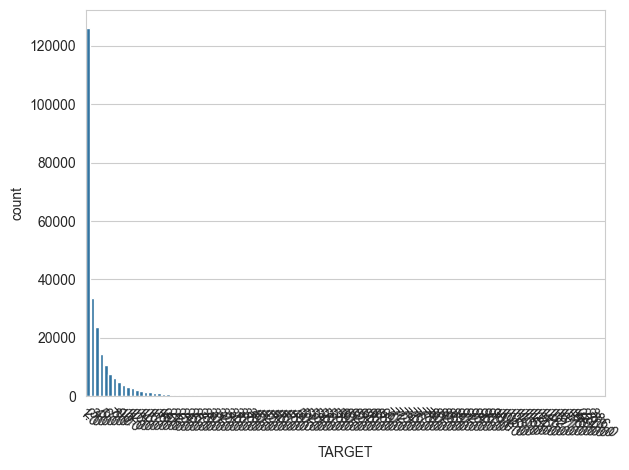

In [51]:
sns.barplot(target_vc)
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

## Browser

In [62]:
display(train['browser'].unique())
display(len(train['browser'].unique()))

array(['Chrome', 'Samsung Internet', 'Firefox', 'Opera',
       'Safari (in-app)', 'Edge', 'Safari', 'Android Webview',
       'UC Browser', 'Internet Explorer', 'Opera Mini', 'BlackBerry',
       'Android Browser', 'Amazon Silk', 'Coc Coc', 'YaBrowser',
       'Nintendo Browser', 'Nokia Browser', 'MRCHROME', 'Puffin',
       'Mozilla Compatible Agent', 'Maxthon', '+Simple Browser',
       'Apple-iPhone7C2', 'Playstation Vita Browser',
       'osee2unifiedRelease', 'SAMSUNG-SM-B355E Opera', 'DESKTOP', 'Iron',
       'Browser', 'rpfanjzoxyemsgbtichqkudwlv',
       'cajrnbtvqwfkolzyxushpdgime', 'wvsmagudcqeytijorlhxnfzkbp',
       'efkaxnbyohqtspzlvcwrjmigdu', 'bsfnwveckhgpdoyjxmizruqtla',
       'Mozilla', 'Konqueror', 'Netscape', 'Amazon.com', 'SeaMonkey',
       ';__CT_JOB_ID__:76fd1acb-e365-43c0-b967-908bcf5d5b59;',
       'eosutpkiahjzvdgcwxlmyfqbrn', 'cnwmpegudakrqzljtvfxohbysi',
       'fspmihbxzowgnuctrqykjlvade', 'YE',
       ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;

70

In [66]:
browser_vc = train['browser'].value_counts()
display(browser_vc[browser_vc == 1])
display(browser_vc[browser_vc > 1])

browser
bsfnwveckhgpdoyjxmizruqtla                              1
;__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;    1
;__CT_JOB_ID__:4333777f-bb0c-4a18-935e-df5658dbce2d;    1
;__CT_JOB_ID__:2547db0b-ec43-452a-a0d4-ff42b7dc7907;    1
;__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;    1
;__CT_JOB_ID__:a7ed0808-e70c-4b19-b1a3-1018bbb7dc7f;    1
;__CT_JOB_ID__:85da5736-a78e-45a9-837e-f5a53e5cd725;    1
;__CT_JOB_ID__:a24a8978-e5e8-4dc9-af66-c4ed89ea25d7;    1
;__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;    1
Netscape                                                1
Lunascape                                               1
;__CT_JOB_ID__:0b39e7ca-1431-42e3-ba1f-9d8951a65840;    1
;__CT_JOB_ID__:6e9dcf2f-f58f-4938-91e3-77e00868177b;    1
starmaker                                               1
;__CT_JOB_ID__:97909e28-4228-4b55-8ad5-cc791f2b583c;    1
;__CT_JOB_ID__:0a075729-93a5-43d0-9638-4cbd41d5f5a5;    1
;__CT_JOB_ID__:58e2ecba-7666-4a10-b498-8216457ce472;    1
;__CT_

browser
Chrome                      174395
Safari                       35689
Android Webview              13855
Firefox                       8436
Internet Explorer             4573
Edge                          3702
Samsung Internet              3077
Opera Mini                    3041
Safari (in-app)               1995
Opera                         1331
UC Browser                     901
YaBrowser                      402
Amazon Silk                    257
Coc Coc                        206
Mozilla Compatible Agent       124
Android Browser                110
Puffin                          55
MRCHROME                        15
Nokia Browser                   13
BlackBerry                      13
Maxthon                         11
Playstation Vita Browser         9
Nintendo Browser                 7
DESKTOP                          5
Iron                             4
SeaMonkey                        4
Konqueror                        3
Browser                          3
Mozilla     

## OS

In [67]:
train['OS'].value_counts()

OS
Windows             88119
Macintosh           60316
Android             51870
iOS                 29778
Linux                9562
Chrome OS            9222
(not set)            2592
Tizen                 321
Samsung               259
Windows Phone         128
OS/2                   36
Xbox                   31
BlackBerry             29
Playstation Vita        9
Nintendo 3DS            6
Firefox OS              4
FreeBSD                 3
SunOS                   1
Nintendo WiiU           1
SymbianOS               1
Nokia                   1
Name: count, dtype: int64

## device

In [69]:
display(train['device'].value_counts())
display(train['device'].value_counts(normalize=True))

device
desktop    167133
mobile      76460
tablet       8696
Name: count, dtype: int64

device
desktop    0.662466
mobile     0.303065
tablet     0.034468
Name: proportion, dtype: float64